# Lab 5 Simon Palm and Erik Lindvall
Some of the results are in the prints following the code cells. Note that the "painter_play" algorithm has been copied from the provided github repository

In [19]:
import numpy as np 
import random
import math 

# %Floor painter algorithm
# %Code translated into python Fiona Skerman from matlab code written by Alex Szorkovszky for UU Modelling Complex Systems

# %INPUTS
# %rules: 54-cell array with one of three actions: 0(no turn) 1(turn left) 2(turn right) 3(random turn left/right)
# %room: MxN matrix defining a rectangular room with each square either 0(empty) or 1(furniture) or 2(painted)


# Chromosome (54-cell rule array) encodes action for each of 54 different scenarios
# no turn, turn left, turn right, turn left/right with 50/50 
# let [c, f, l, r] denote the states of current, forward, left and right squares, 
# then rule for that position is at position i=2(9f+3l+r)+Indicator[c=2] in chromosone.


#Painter has a position x,y in MxN matrix, and a direction -1 Left, 0 Up, 1 Right, -2 Down.

# Each time step consists of three parts
# a) according to rule on current environment update direction either 0 no turn, 1 turn left, 2 turn right, 3 random turn left/right
# b) if on unpainted square, paint it
# c) go forwards if possible

# OUTPUTS
# score: percentage of empty space painted
# xpos: x positions over time
# ypos: y positions over time



def painter_play(rules,room):
  #returns score, xpos, ypos

  M, N = room.shape

  #Calculates number of squares t to be painted. / #steps allowed
  t=M*N - room.sum()
  t=int(t)


  # add walls
  # env 0 - empty square, 1 - wall/obstruction, 2 - painted square
  env = np.ones((M+2,N+2))
  for i in range(1, M+1):
    for j in range(1, N+1):
      env[i][j]=0

  #new room size including walls
  M=M+2
  N=N+2

  xpos=[np.nan]*(t+1)
  ypos=[np.nan]*(t+1)

  # %random initial location   
  while True:
    xpos[0]=math.floor(M*random.random())
    ypos[0]=math.floor(N*random.random())
    if env[xpos[0], ypos[0]] == 0:
      break


  # random itial orientation (up=0,left=-1,right=+1,down=-2)
  direction = math.floor(4*random.random()) - 2

  # initial score
  score = 0

  for i in range(t):
    # directions -1: Left, 0: Up, 1: Right, 2: Down
    # dx, dy of a forward step (given current direction)        
    dx = divmod(direction,2)[1]
    if direction == -1:
      dx = -1 * dx

    dy = divmod(direction+1,2)[1]
    if direction == -2: 
      dy = -1*dy




    # dx, dy of a square to right (given currection direction)  
    r_direction=direction+1
    if r_direction == 2:
      r_direction = -2

    dxr = divmod(r_direction,2)[1]
    if r_direction == -1:
      dxr = -1 * dxr
    dyr = divmod(r_direction+1,2)[1]
    if r_direction == -2: 
      dyr = -1*dyr

    # evaluate surroundings (forward,left,right)
    local = [env[xpos[i] + dx, ypos[i] + dy], env[xpos[i] - dxr, ypos[i] - dyr], env[xpos[i] + dxr, ypos[i] + dyr]]      
      
    #localnum= 2* np.dot([9,3,1], local) if env[xpos[i], ypos[i]] == 2 else 2* np.dot([9,3,1], local) + 1
    localnum= int(2* np.dot([9,3,1], local))
    if env[xpos[i], ypos[i]] == 2:
       localnum += 1
     
    #use turning rule 1 'turn left', 2 'turn right', 3 'turn left/right 50/50 probabilities'
    if rules[localnum] == 3:
      dirchange = math.floor(random.random()*2)+1
    else:
      dirchange = rules[localnum]

    if dirchange == 1:
      direction = direction - 1
      if direction == -3:
        direction = 1
    elif dirchange == 2:
      direction = direction + 1
      if direction == 2:
        direction = -2

    dx = divmod(direction,2)[1]
    if direction == -1:
      dx = -1 * dx

    dy = divmod(direction+1,2)[1]
    if direction == -2: 
      dy = -1*dy  

    # paint square
    if env[xpos[i],ypos[i]]==0:
      env[xpos[i],ypos[i]] = 2
      score = score + 1
      
    # go forward if possible - stay put if wall/obstacle ahead
    if env[xpos[i]+dx, ypos[i]+dy] == 1:
      xpos[i+1] = xpos[i]
      ypos[i+1] = ypos[i]
    else:
      xpos[i+1] = xpos[i]+dx
      ypos[i+1] = ypos[i]+dy      
  

  # %normalise score by time            
  score = score/t  

  return score, xpos, ypos, #env


#Creates a random chromosome (strategy)
def create_chromosome():
    return np.random.randint(0, 4, size=54)


#Creates a room with random furniture of size M x N
def create_room(M,N):
    R = np.zeros([M,N])
    for i in range(M):
        for j in range(N):
            if random.random()<0.20: #10% chance that a room square has furniture on it
                R[i][j] = 1
    return R


#Mutates a random gene in the Chromosome with chosen probability (kan göras så att den inte har en chans att välja samma gen igen)
def mutate_chromosome(C,p):
    if random.random()<p: 
        ind = random.randint(0,53)
        C[ind] = random.randint(0,3) 
    return C


#Crosses over two chosen chromosomes at a random splitpoint
def crossover_chromosomes(C1,C2):
    splitind = random.randint(0, 53)
    try:
      C = np.concatenate((C1[:splitind], C2[splitind:]))
      return C
    except:
      print(C1)
      print(C2)
      C = np.concatenate((C1[:splitind], C2[splitind:]))
      return C
       

    

#Generates an ofspring from two chosen chromosomes with a mutation probability (kombinerar bara de två ovanstående metoder, kan tas bort)
def generate_offspring(C1,C2,mp):
    new_C = crossover_chromosomes(C1,C2) #Generates an offspring
    new_C = mutate_chromosome(new_C,mp) #mutates one random gene of the new chromosome with prob 0.05
    return new_C

#Generates a new generation of chromosomes ()
def next_generation(Chromosomes,Room,Scores):
  new_Scores = {}
  new_Chromosomes = {}
  for i in range(len(Chromosomes)):
      C1 = random.choice(list(Chromosomes.values()))
      if i < 10: #The top 10 highest fitness chromosomes get 2 offsprings with a random other chromosome
          C2 = random.choice(list(Chromosomes.values()))
          ind = list(Scores.keys())[i]
          ind2 = list(Scores.keys())[-i-1]
          C = Chromosomes[ind]
          C_new1 = generate_offspring(C,C1,0.005)
          C_new2 = generate_offspring(C,C2,0.005)
          prob1, xpos, ypos = painter_play(C_new1,Room)
          prob2, xpos, ypos = painter_play(C_new2,Room)
          new_Chromosomes[ind] = C_new1
          new_Chromosomes[ind2] = C_new2
          new_Scores[ind] = prob1
          new_Scores[ind2] = prob2
      elif i > 9 and i < 90: #All other chromosomes except the 10 with lowest fitness get 1 offspring
          ind = list(Scores.keys())[i]
          C = list(Chromosomes.values())[ind]
          C_new = generate_offspring(C,C1,0.005)
          prob, xpos, ypos = painter_play(C_new,Room)
          new_Chromosomes[ind] = C_new
          new_Scores[ind] = prob
  new_Scores = dict(sorted(new_Scores.items(), key = lambda item: item[1] ,reverse=True))
  new_Chromosomes = {key:new_Chromosomes[key] for key in new_Scores.keys()}
  return new_Chromosomes,new_Scores   

In [20]:
Room = create_room(30,60)
Chromosomes = {}
Scores = {}
for i in range(100): # Should be 100 later
    C = create_chromosome()
    score, xpos, ypos = painter_play(C,Room)
    Chromosomes[i] = C
    Scores[i] = score

Scores = dict(sorted(Scores.items(), key = lambda item: item[1] ,reverse=True)) #Sorts chromosomes by fitness (lowest first)
old_Chromosomes = Chromosomes
old_Scores = Scores



n_generations = 200 #Ska vara 200 men 10 är bättre för tester 
for gen in range(n_generations):
    Chromosomes, Scores = next_generation(Chromosomes,Room,Scores)


#Probs_old = ["{:.3f}".format(list(P)) for P in old_Chromosomes.items()] 
#Probs_new = ["{:.3f}".format(list(P)) for P in Chromosomes.items()] 
Probs_old = [P for P in old_Scores.values()] 
Probs_new = [P for P in Scores.values()]

#Borde vara samma längd men varierar över olika runs
print(len(Probs_old))
print(len(Probs_new))
print(np.mean(Probs_old))
print(np.mean(Probs_new))




100
100
0.08635793871866296
0.8514972144846797


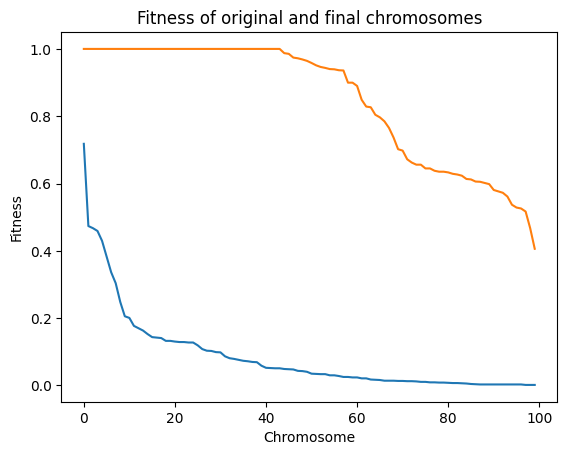

1.0


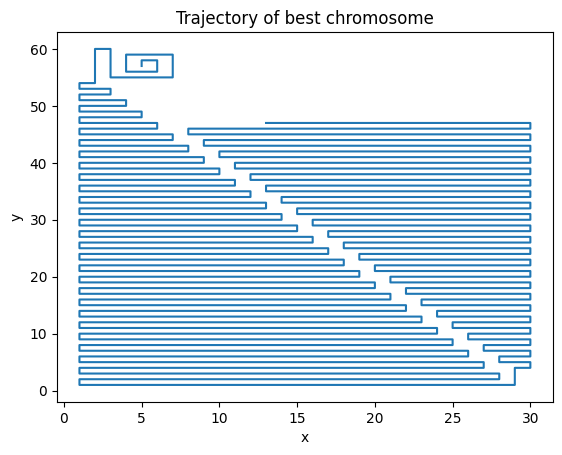

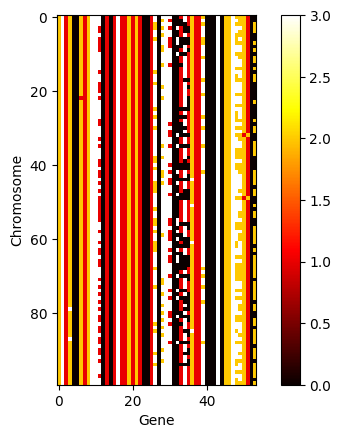

In [21]:
# Plot the resulting chromosomes
import matplotlib.pyplot as plt
plt.plot(Probs_old)
plt.plot(Probs_new)
plt.ylabel('Fitness')
plt.xlabel('Chromosome')
plt.title('Fitness of original and final chromosomes')
plt.show()

# Plot the trajectory for the best chromosome
best_chromosome = list(Scores.keys())[0]
best_score,best_xpos,best_ypos = painter_play(Chromosomes[best_chromosome],Room)
print(best_score)
plt.plot(best_xpos,best_ypos)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Trajectory of best chromosome')
plt.show()

# Plot the genes for all the chromosomes with colorbar
plt.imshow(list(Chromosomes.values()), cmap='hot', interpolation='nearest')
plt.xlabel('Gene')
plt.ylabel('Chromosome')
plt.colorbar()
plt.show()




# Part 2

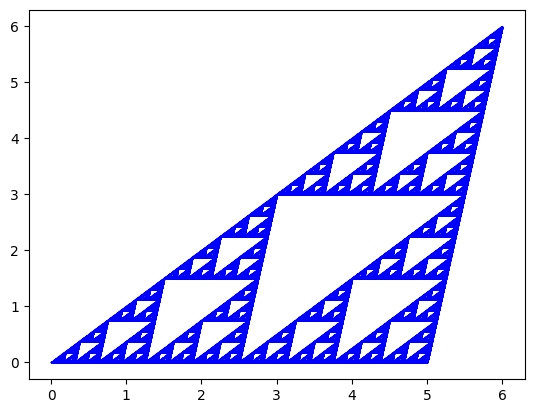

In [22]:
# Select three points in a plane
import numpy as np
import matplotlib.pyplot as plt
import random

#Points to be selected
point1 = np.array([0,0])
point2 = np.array([5,0])
point3 = np.array([6,6])
points = [point1,point2,point3]


def step(curr,points,p1=1/3,p2=1/3,p3=1/3):
    # Randomly select a point from the list
    rnd = np.random.rand()
    if rnd < p1:
        point = points[0]
    elif rnd < p1+p2:
        point = points[1]
    else:
        point = points[2]
    
    # move half the length
    return (curr + point)/2

def random_start(points):
    r1 = random.random()
    r2 = random.random()

    sqrt_r1 = pow(r1, 0.5)
    x = (1 - sqrt_r1) * points[0][0] + (sqrt_r1 * (1 - r2)) * points[1][0] + (sqrt_r1 * r2) * points[2][0]
    y = (1 - sqrt_r1) * points[0][1] + (sqrt_r1 * (1 - r2)) * points[1][1] + (sqrt_r1 * r2) * points[2][1]

    return np.array([x, y])

    
N = 10**6
curr_pos = np.zeros((N,2))
curr_pos[0] = random_start(points)

for i in range(N-1):
    curr_pos[i+1] = step(curr_pos[i],points,p1 = 1/3,p2 = 1/3,p3 = 1/3)

plt.plot(curr_pos[100:-1,0],curr_pos[100:-1,1], 'b.',markersize=0.1)
plt.show()



# Question 1
When they are equal we get something similar to that of Serpinski triangle, but with a transformation as we do not use a equal sided triangle. If they are not equal it will attract to one of the vertices and not creating the illusion of a triangle.

# Question 2
As mentioned above we get the Serpinski triangle. Because of this we get the three affine functions:

P = point in triangle, $P_i$ is one of the vertives. i = {1,2,3}

$f_i(P) = \frac{P+P_i}{2}$

And the Huthinson operator is therefore.
$F(P) = \bigcup^3_{i=1} f_i(P)$